# 02. Neural network classification with pytorch

In [1]:
# Data

from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state = 42)


In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X:\n {X[:5]} ")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
import pandas as pd

df = pd.DataFrame({"X1": X[:, 0],
                   "X2": X[:, 1],
                   "label" : y})

df.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


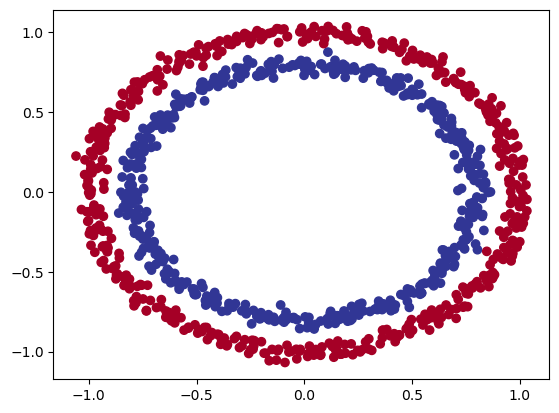

In [5]:
# Visualise

import matplotlib.pyplot as plt

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)


In [6]:
# View the first example of features and label
X_sample = X[0]
y_sample = y[0]
 
print(f"Value for one sample of x: {X_sample} and the same for y: {y_sample}")
print(f"Shape for one sample of x: {X_sample.shape} and the same for y: {y_sample.shape}")

Value for one sample of x: [0.75424625 0.23148074] and the same for y: 1
Shape for one sample of x: (2,) and the same for y: ()


In [7]:
import torch
torch.__version__

'2.9.1+cu128'

In [8]:
# Converting numpy type into tensor

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

##  1. Splitting data


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [11]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:

1. Set up device-agnostic code so our code will run on an accelerator (GPU) if there is one  
2. Construct a model (by subclassing `nn.Module`)  
3. Define a loss function and optimizer  
4. Create a training and test loop  


In [12]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module`  
   *(almost all models in PyTorch subclass `nn.Module`)*

2. Creates 2 `nn.Linear()` layers that are capable of handling the shapes of our data  

3. Defines a `forward()` method that outlines the forward pass  
   *(or forward computation) of the model*  

4. Instantiates an instance of our model class and sends it to the target device


In [13]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4130,  0.5914],
                      [ 0.5514, -0.6170],
                      [ 0.0388, -0.3055],
                      [-0.1639, -0.3696],
                      [-0.4960, -0.2017]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.5919,  0.1884, -0.4085, -0.0836, -0.3895], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3975, -0.2567,  0.1517,  0.2269,  0.1087]], device='cuda:0')),
             ('1.bias', tensor([-0.2286], device='cuda:0'))])

In [16]:
# Predicting a model
with torch.no_grad():
    untrained_pred = model_0(X_test.to(device))
    print(f"Length of predictions: {len(untrained_pred)}, Shape: {untrained_pred.shape}")
    print(f"Length of test: {len(X_test)}, Shape: {X_test.shape}")
    print(f"\nFirst 10 predictions: \n{untrained_pred[:10]}")
    print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[-0.6450],
        [-0.8612],
        [-0.2887],
        [-0.7451],
        [-0.6227],
        [-0.7520],
        [-1.0960],
        [-1.0713],
        [-0.2752],
        [-0.8794]], device='cuda:0')

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [17]:
# Set up loss function

loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [18]:
# Calculate 100 accuracy out of 100 samples
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## Train model 

to build a model we have to make a training loop

## 3.1 Going from raw logits → prediction probabilities → prediction labels

Our model outputs are going to be **raw logits**.

We can convert these **logits** into **prediction probabilities** by passing them through some kind of activation function  
(e.g. **sigmoid** for binary classification and **softmax** for multiclass classification).

Then we can convert our model’s **prediction probabilities** to **prediction labels** by either **rounding** them  
or taking the **`argmax()`**.


In [19]:
# view the first 5 output of the forward pass of the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.6450],
        [-0.8612],
        [-0.2887],
        [-0.7451],
        [-0.6227]], device='cuda:0')

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [21]:
# Use the sigmoid activation function on out model logits

y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.3441],
        [0.2971],
        [0.4283],
        [0.3219],
        [0.3492]], device='cuda:0')

In [22]:
y_pred = torch.round(y_pred_prob)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]

print(torch.eq(y_pred.squeeze(), y_pred_labels.squeeze()))

y_pred.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

# Building the training and testing loop

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 100

for epoch in range(epochs):
    model_0.train()

    # Doing the forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Applying loss fn and accuracy
    loss = loss_fn(y_logits,y_train)

    acc = accuracy_fn(y_true=y_train, y_pred = y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Back propogation
    loss.backward()

    # Optimizer step
    optimizer.step()

    ## Model evaluation
    model_0.eval()
    with torch.inference_mode():

        # forward pass for test
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate the loss and accuracy
        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true = y_test,
                          y_pred = test_pred)

    
    # See whats happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.75358 | Acc: 50.00% | Test Loss: 0.74088 | Test Acc: 50.00%
Epoch: 10 | Loss: 0.71712 | Acc: 50.00% | Test Loss: 0.70917 | Test Acc: 50.00%
Epoch: 20 | Loss: 0.70355 | Acc: 42.50% | Test Loss: 0.69803 | Test Acc: 42.50%
Epoch: 30 | Loss: 0.69816 | Acc: 45.62% | Test Loss: 0.69408 | Test Acc: 50.50%
Epoch: 40 | Loss: 0.69591 | Acc: 47.25% | Test Loss: 0.69277 | Test Acc: 51.00%
Epoch: 50 | Loss: 0.69490 | Acc: 48.50% | Test Loss: 0.69242 | Test Acc: 50.00%
Epoch: 60 | Loss: 0.69441 | Acc: 48.75% | Test Loss: 0.69240 | Test Acc: 50.50%
Epoch: 70 | Loss: 0.69413 | Acc: 49.62% | Test Loss: 0.69249 | Test Acc: 51.00%
Epoch: 80 | Loss: 0.69395 | Acc: 50.38% | Test Loss: 0.69261 | Test Acc: 50.00%
Epoch: 90 | Loss: 0.69382 | Acc: 50.25% | Test Loss: 0.69272 | Test Acc: 50.00%


# Make predicions and evaluate the model

In [24]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


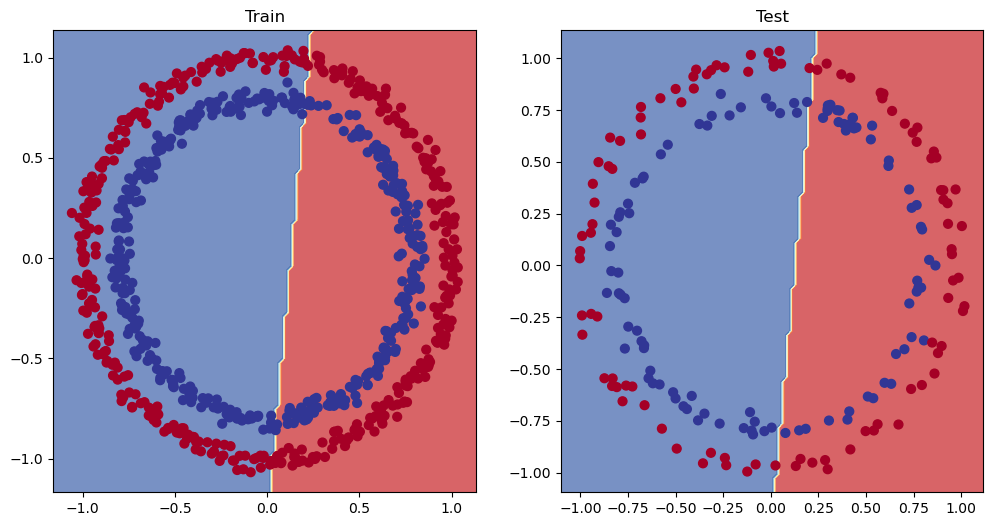

In [25]:
# Visualizing the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test,y_test)

In [26]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features = 10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [27]:
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, 

In [28]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Creating an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [29]:
# Creating a training and testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


epochs = 100
for epoch in range(epochs):
    model_1.train()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #loss function
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred = y_pred)

    # optimizer zero grad
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    # Optimizer step
    optimizer.step()

    ## Evaluating model
    model_1.train()
    with torch.inference_mode():

        # Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.69261 | Test Acc: 51.00%


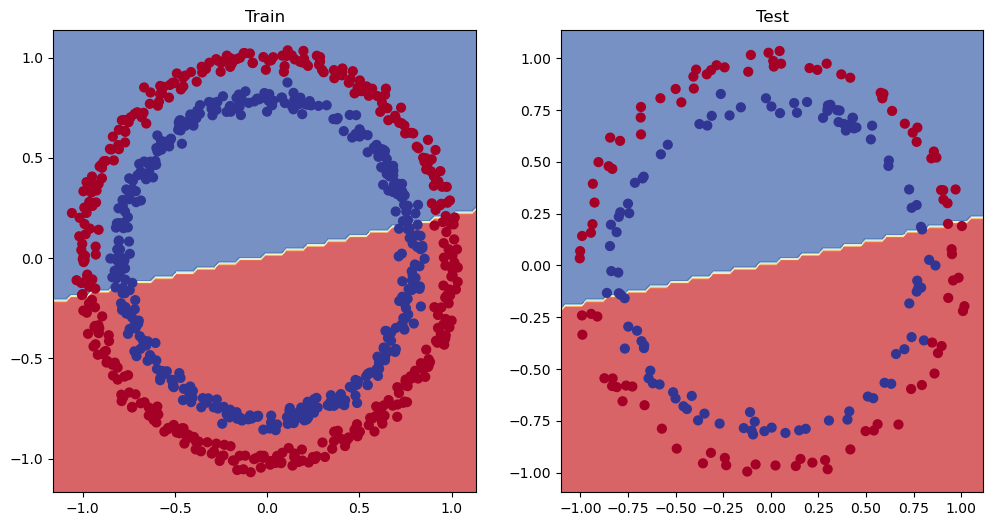

In [30]:
# Visualizing the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test,y_test)

## 6. The missing piece: non-linearity

> *What patterns could you draw if you were given an infinite amount of straight and non-straight lines?*

Or in machine learning terms, an infinite (but really it is finite) set of linear and non-linear functions?


### 6.1 Recreating non-linear data (red and blue circles)



In [31]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X,y = make_circles(n_samples, noise=0.03, random_state=42)

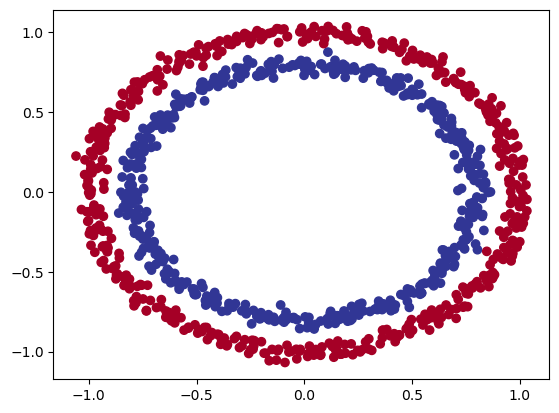

In [32]:
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [33]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

X_train[:5], X_test[:5],y_train[:5],X_test[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438]]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438]]))

## Build a model with non linearity

In [34]:
# Build a model with non linear activation function

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=20)
        self.layer_2 = nn.Linear(in_features=20, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2().to(device)
model_2.to(device)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [35]:
# Applying loss and optimizer 

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr = 0.1)

In [36]:
# Creating an training and testing loop of the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, X_test = X_train.to(device),X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()

    # Forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Loss function
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)
    
    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()
    
    # Optimizer step
    optimizer.step()

    # Model Evaluation
    model_2.eval()
    with torch.inference_mode():
        
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,  y_test)
        test_acc = accuracy_fn(y_true = y_test,
                      y_pred = test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss:  {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69478 | Acc: 43.88% | Test Loss:  0.69517 | Test Acc: 47.50%
Epoch: 100 | Loss: 0.69125 | Acc: 58.25% | Test Loss:  0.69197 | Test Acc: 53.50%
Epoch: 200 | Loss: 0.68889 | Acc: 53.62% | Test Loss:  0.68924 | Test Acc: 54.00%
Epoch: 300 | Loss: 0.68550 | Acc: 60.88% | Test Loss:  0.68548 | Test Acc: 64.50%
Epoch: 400 | Loss: 0.67918 | Acc: 67.00% | Test Loss:  0.67917 | Test Acc: 69.00%
Epoch: 500 | Loss: 0.66758 | Acc: 68.75% | Test Loss:  0.66830 | Test Acc: 73.50%
Epoch: 600 | Loss: 0.64409 | Acc: 80.00% | Test Loss:  0.64764 | Test Acc: 79.50%
Epoch: 700 | Loss: 0.59269 | Acc: 92.62% | Test Loss:  0.60398 | Test Acc: 91.50%
Epoch: 800 | Loss: 0.48951 | Acc: 97.75% | Test Loss:  0.51283 | Test Acc: 97.00%
Epoch: 900 | Loss: 0.33257 | Acc: 99.25% | Test Loss:  0.36625 | Test Acc: 99.00%


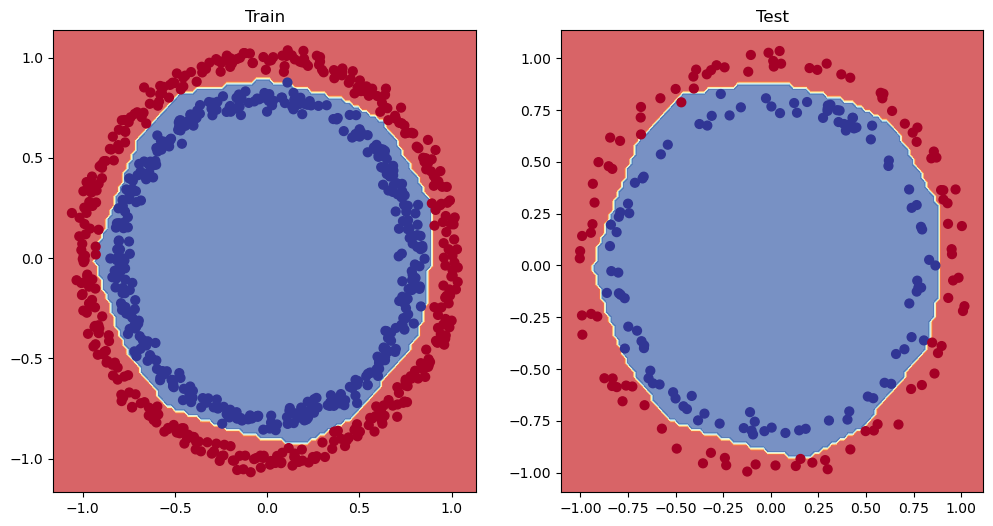

In [37]:
# Visualizing the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test,y_test)

In [38]:
# Evaluating the model
model_2.to(device)
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

# Now moving on to multiclass classification model

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


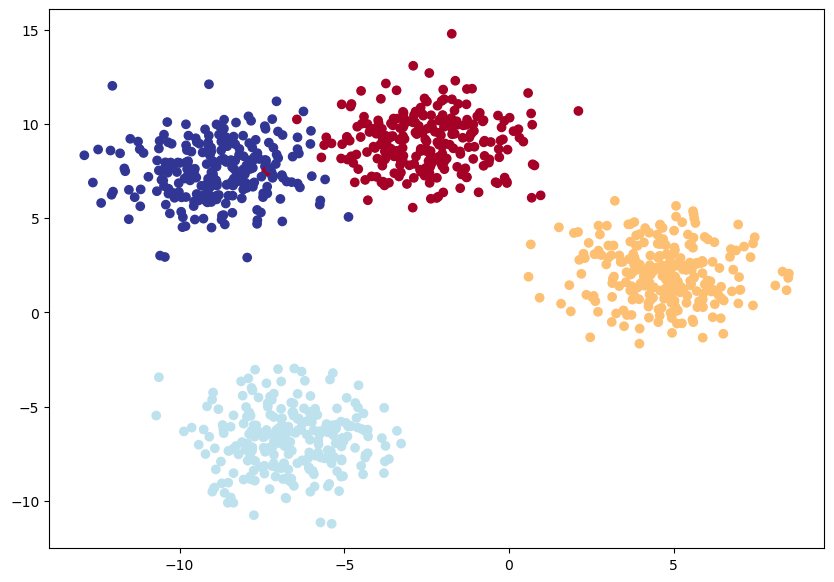

In [39]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [40]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

# Creating a Model

In [41]:
class BlobModel(nn.Module):
    def __init__(self, in_feature, out_feature, hidden_layer=8):
        super().__init__()
        self.layer_block = nn.Sequential(
            nn.Linear(in_features=in_feature, out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer, out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer, out_features=out_feature)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.layer_block(x)

model_3 = BlobModel(in_feature=2,
                   out_feature=4,
                   hidden_layer=8).to(device)
model_3

BlobModel(
  (layer_block): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [42]:
# Loss fn and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr = 0.1)

In [43]:
# Training and Testing Loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device) 
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

epochs = 100

for epoch in range(epochs):
    model_3.train()
    
    # do the forward pass
    y_logits = model_3(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    # y_pred = torch.argmax(y_pred_prob, dim=1)

    # Calculate the loss
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true = y_blob_train,
                      y_pred = y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    # Optimizer step
    optimizer.step()

    ## Test Loop
    model_3.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_3(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # test_pred = torch.argmax(test_pred_prob, dim=1)

        # Loss test
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true = y_blob_test,
                               y_pred = test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883 | Acc: 40.38% | Test Loss: 1.07554 | Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476 | Acc: 96.75% | Test Loss: 0.66069 | Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535 | Acc: 98.50% | Test Loss: 0.43074 | Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294 | Acc: 99.12% | Test Loss: 0.24508 | Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232 | Acc: 99.25% | Test Loss: 0.10229 | Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627 | Acc: 99.25% | Test Loss: 0.05848 | Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068 | Acc: 99.25% | Test Loss: 0.04293 | Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300 | Acc: 99.25% | Test Loss: 0.03491 | Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836 | Acc: 99.25% | Test Loss: 0.02988 | Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525 | Acc: 99.25% | Test Loss: 0.02663 | Test Acc: 99.50%


In [44]:
model_3.eval()
with torch.inference_mode():
    y_logits = model_3(X_blob_test.to(device))

y_logits[:10], y_blob_test[:10]

(tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
         [-2.1738, -6.3750, -3.7202,  3.1203],
         [-3.4102, -3.8958,  3.1567, -2.6119],
         [-1.1505,  4.1962, -3.8472, -4.8820],
         [ 3.7548, -1.3391, -9.1422, -6.9466],
         [-2.8211, -7.5767, -4.2944,  3.7944],
         [-3.0306, -3.3328,  2.7955, -2.1374],
         [ 3.3761, -4.0375, -6.8987, -3.5503],
         [-4.3620, -4.9904,  3.8123, -3.3814],
         [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

In [45]:
y_pred_prob = torch.softmax(y_logits, dim=1)
y_pred_prob

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04],
        [9.8959e-01, 6.0435e-04, 2.1069e-04, 9.5951e-03],
        [2.4120e-04, 9.9976e-01, 1.1916e-07, 5.0572e-08],
        [9.9769e-01, 2.2633e-03, 3.3543e-06, 4.7313e-05],
        [9.9943e-01, 3.7486e-04, 4.8504e-06, 1.8694e-04],
        [9.9958e-01, 3.6371e-04, 1.3937e-06, 5.5475e-05],
        [3.7464e-02, 3.4841e-04, 2.0396e-03, 9.6015e-01],
        [3.6034e-03, 5.5087e-05, 9.8942e-04, 9.9535e-01],
        [6.834

In [46]:
y_preds = torch.argmax(y_pred_prob, dim=1)
y_pred[:10] , y_blob_test[:10]

(tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

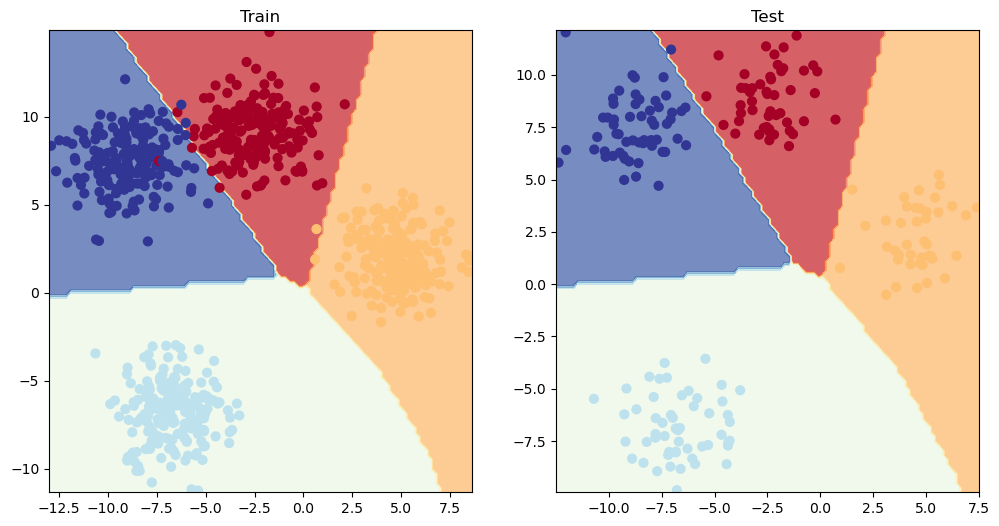

In [47]:
# Visualizing the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_blob_test,y_blob_test)